# Cellular Component (CC) Prediction Pipeline
This notebook implements a MLM for predicting Gene Ontology (GO) Cellular Component annotations for proteins.
Sequence information is incorporated through precomputed ProtT5 embeddings and InterPro domain features.

### 1. Imports

In [1]:
# importing necessary packages

import os
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score

import pickle

### 2. Setup

In [2]:
# setting a seed

seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

In [3]:
# defining paths

train_dir  = "data/train/final_data" 
meta_dir   = "metadata/CC"

os.makedirs(meta_dir, exist_ok=True) # to store working files

x_path      = os.path.join(train_dir, "X_train.npy")
y_cc_path   = os.path.join(train_dir, "Y_cc_train.npy")

cc_keep_npy    = os.path.join(meta_dir, "go_terms.npy")     
go_cc_map_pkl  = os.path.join(meta_dir, "go_map.pkl")   
CC_model_path  = os.path.join(meta_dir, "cc_model.keras")
scaler_path    = os.path.join(meta_dir, "embed_scaler.pkl")

### 3. Input Data

The model uses numerical feature representations of protein sequences and domain annotations.
Specific inputs are: 
- ProtT5 embeddings (raw FASTA sequences are used to generate them - );
- InterPro domain features;
- CC training labels from currated GO annotations.

In [4]:
# loading data

X      = np.load(x_path)      # preprocessed training data = (123696,2024)
Y_cc   = np.load(y_cc_path)   # CC training labels         = (123969, 677)

print("X:", X.shape, "Y_cc:", Y_cc.shape) #checkpoint

X: (123969, 2024) Y_cc: (123969, 677)


### 4. Feature Construction

This segment has :
- Separation of InterPro domain features and ProtT5 embedding features from orignal matrix. Reasoning: InterPro domain features are binary and ProtT5 embedding features are continuous.
- CC-filtering is used to remove proteins without at least one CC-label (optional, but preferred).
- Embeddings are scaled i.e features are normalised, and a final feature matrix is created.

In [5]:
interpro_dim = 1000
embeded_dim = X.shape[1] - interpro_dim
assert embeded_dim > 0, "Embedding dimension inferred <= 0; check interpro_dim."

X_domains = X[:, :interpro_dim].astype(np.float32)  # keep as 0/1 float
X_embed   = X[:, interpro_dim:].astype(np.float32)

In [6]:
# CC label filtering

use_cc_mask = True # can be turned of, not recommended 
if use_cc_mask:
    mask = (Y_cc.sum(axis=1) > 0)
    X_domains = X_domains[mask]
    X_embed   = X_embed[mask]
    Y_cc      = Y_cc[mask]
    print("After CC mask, X:", (X_domains.shape[0], X_domains.shape[1] + X_embed.shape[1]), "Y:", Y_cc.shape)

After CC mask, X: (84638, 2024) Y: (84638, 677)


In [7]:
# Feature normalization

scaler = StandardScaler()
X_embed_scaled = scaler.fit_transform(X_embed)

with open(scaler_path, "wb") as f:
    pickle.dump(scaler, f)

X_scaled = np.concatenate([X_domains, X_embed_scaled], axis=1) # reassembling matrix

### 5. CC Model and Training
This segment:
- Adresses class imbalance with weighed binary cross-entropy loss.
Reasoning: all GO sub-ontology predictions are highly imbalanced and multilevel problems. Positive labels have a high rarity.
- Model architecture: 3 hidden layers with ReLU activation, batch normalization and dropout for regularization. A sigmoid output layer gives independent probabilities for each term.
- Optimization using Adam
- Model training with an 85/15 train/validation split.

In [8]:
# train_test_split
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, Y_cc, test_size=0.15, random_state=seed
)

y_train = y_train.astype(np.float32)
y_val   = y_val.astype(np.float32)

print("Train:", X_train.shape, y_train.shape, "Val:", X_val.shape, y_val.shape)

Train: (71942, 2024) (71942, 677) Val: (12696, 2024) (12696, 677)


In [9]:
# BCE

pos_weight = 8.0  # tuned on validation data

def weighted_bce(y_true, y_pred):
    # elementwise BCE
    bce = tf.keras.backend.binary_crossentropy(y_true, y_pred)
    # upweight positives
    weights = y_true * pos_weight + (1.0 - y_true)
    return tf.reduce_mean(weights * bce)

In [10]:
# Layers

model = Sequential([
    Dense(2048, activation="relu", input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.4),

    Dense(1024, activation="relu"),
    BatchNormalization(),
    Dropout(0.3),

    Dense(512, activation="relu"),
    BatchNormalization(),
    Dropout(0.3),

    Dense(y_train.shape[1], activation="sigmoid")
])

In [11]:
# loss function and optimization

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=weighted_bce
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2048)              4147200   
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 1024)              2098176   
                                                                 
 batch_normalization_1 (Batc  (None, 1024)             4096      
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0

In [12]:
# early stopping

callbacks = [
    EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True
    )
]

In [13]:
# model training

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=256,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
282/282 [==============================] - 20s 67ms/step - loss: 0.3176 - val_loss: 0.1426
Epoch 2/50
282/282 [==============================] - 19s 68ms/step - loss: 0.1385 - val_loss: 0.1298
Epoch 3/50
282/282 [==============================] - 21s 76ms/step - loss: 0.1283 - val_loss: 0.1228
Epoch 4/50
282/282 [==============================] - 20s 72ms/step - loss: 0.1230 - val_loss: 0.1208
Epoch 5/50
282/282 [==============================] - 21s 73ms/step - loss: 0.1179 - val_loss: 0.1172
Epoch 6/50
282/282 [==============================] - 19s 67ms/step - loss: 0.1153 - val_loss: 0.1160
Epoch 7/50
282/282 [==============================] - 19s 68ms/step - loss: 0.1121 - val_loss: 0.1138
Epoch 8/50
282/282 [==============================] - 20s 70ms/step - loss: 0.1090 - val_loss: 0.1132
Epoch 9/50
282/282 [==============================] - 20s 71ms/step - loss: 0.1064 - val_loss: 0.1124
Epoch 10/50
282/282 [==============================] - 20s 72ms/step - loss: 0.106

In [14]:
#saving the model

model.save(CC_model_path)
print("Saved model to:", CC_model_path)

Saved model to: metadata/CC\cc_model.keras


### 6. Model Evaluation and Thresholding

In [15]:
# defininf micro f1

def micro_f1(y_true, y_prob, thr):
    y_pred = (y_prob >= thr).astype(np.int8)
    tp = (y_pred * y_true).sum()
    fp = (y_pred * (1 - y_true)).sum()
    fn = ((1 - y_pred) * y_true).sum()
    if tp == 0:
        return 0.0
    precision = tp / (tp + fp + 1e-9)
    recall    = tp / (tp + fn + 1e-9)
    return float(2 * precision * recall / (precision + recall + 1e-9))

val_prob = model.predict(X_val, batch_size=512, verbose=0)

In [16]:
# precision-recall curve on the validation set
from sklearn.metrics import precision_recall_curve

y_true = y_val.flatten()
y_score = val_prob.flatten()

precision, recall, _ = precision_recall_curve(y_true, y_score)


In [17]:
# threshold scan on validation set

thresholds = np.arange(0.05, 0.51, 0.01)
best_thr, best_score = None, -1.0
for t in thresholds:
    s = micro_f1(y_val, val_prob, t)
    if s > best_score:
        best_score = s
        best_thr = t

print("Best threshold (micro-F1 scan):", best_thr, "score:", best_score)

Best threshold (micro-F1 scan): 0.5000000000000001 score: 0.6116553991487553


In [18]:
f1 = (2 * precision * recall) / (precision + recall + 1e-12)

best_idx = np.argmax(f1)
best_f1 = f1[best_idx]
best_p = precision[best_idx]
best_r = recall[best_idx]

print(f"Max micro-F1: {best_f1:.4f}")
print(f"At threshold: {best_thr:.4f}")
print(f"Precision: {best_p:.4f}, Recall: {best_r:.4f}")

Max micro-F1: 0.7065
At threshold: 0.5000
Precision: 0.7205, Recall: 0.6931


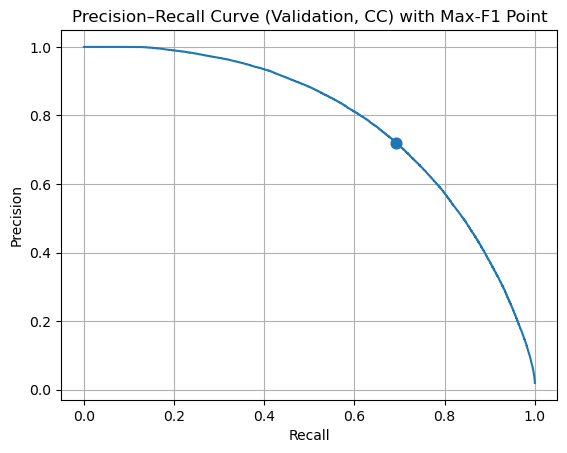

In [19]:
# Plot PR curve + mark max-F1 point
import matplotlib.pyplot as plt
plt.figure()
plt.plot(recall, precision)
plt.scatter([best_r], [best_p], s=60)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Validation, CC) with Max-F1 Point")
plt.grid(True)
plt.show()

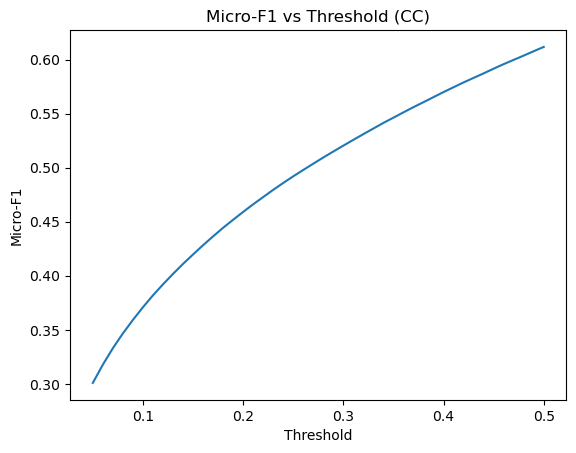

In [20]:
# checking the microF1 vs threshold relationship

scores = []
for t in thresholds:
    scores.append(micro_f1(y_val, val_prob, t))

plt.plot(thresholds, scores)
plt.xlabel("Threshold")
plt.ylabel("Micro-F1")
plt.title("Micro-F1 vs Threshold (CC)")
plt.show()

Micro f1 increases steadily with an increasing decision threshold. The selected threshold will be 0.5, which maximizes validation microF1 and gives more confident CC-annotations, avoiding redundant generic terms.

In [21]:
print("Loading:", cc_keep_npy)
print("Loading:", go_cc_map_pkl)

if not os.path.exists(cc_keep_npy):
    raise FileNotFoundError(f"Missing file: {cc_keep_npy}")

if not os.path.exists(go_cc_map_pkl):
    raise FileNotFoundError(f"Missing file: {go_cc_map_pkl}")

# Load metadata
cc_keep = np.load(cc_keep_npy, allow_pickle=True).tolist()

with open(go_cc_map_pkl, "rb") as f:
    go_cc_map = pickle.load(f)


# Final consistency check
assert len(cc_keep) == y_train.shape[1], "Mismatch: cc_keep vs Y_cc columns"
assert set(go_cc_map.values()) == set(range(len(cc_keep))), "GO index mapping is broken"

print("CC metadata loaded successfully.")

Loading: metadata/CC\go_terms.npy
Loading: metadata/CC\go_map.pkl
CC metadata loaded successfully.
